In [230]:
import xarray as xr
original_climate_data = xr.open_dataset('../data/chad-data-climate.nc')
original_climate_data

<xarray.Dataset> Size: 14MB
Dimensions:     (valid_time: 48, latitude: 166, longitude: 106)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 384B 2020-01-01 ... 2023-12-01
  * latitude    (latitude) float64 1kB 23.5 23.4 23.3 23.2 ... 7.3 7.2 7.1 7.0
  * longitude   (longitude) float64 848B 13.5 13.6 13.7 13.8 ... 23.8 23.9 24.0
    expver      (valid_time) <U4 768B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 3MB ...
    tp          (valid_time, latitude, longitude) float32 3MB ...
    lai_hv      (valid_time, latitude, longitude) float32 3MB ...
    lai_lv      (valid_time, latitude, longitude) float32 3MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-09T09:48 GRIB to CDM+CF via cfgrib-0.9.1...

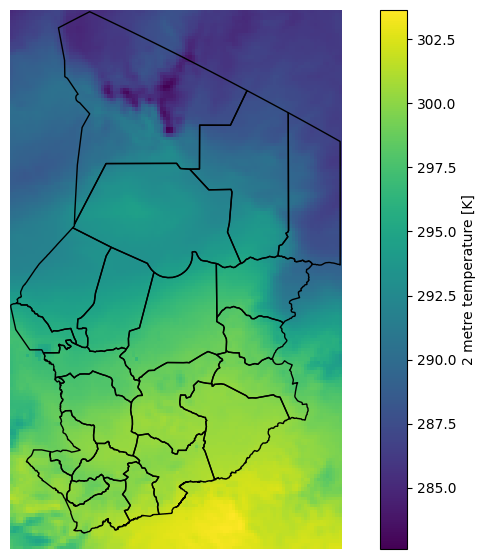

In [315]:
import numpy as  np
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

plt.figure(figsize=(10, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

tps = original_climate_data['t2m'].sel(valid_time='2023-01-01T00:00:00')
tps.plot(ax=ax)

map_data = gpd.read_file('../data/chadgeodata/geoBoundaries-TCD-ADM1-all/geoBoundaries-TCD-ADM1.geojson')
map_data.plot(color='none', edgecolor='black', ax=ax)
plt.axis('off')
plt.title('')
plt.show()

In [382]:
import pandas as pd

df = pd.read_excel('../data/malaria-data.xlsx')
df = df.drop(columns=['Health district/hospital'])
malaria_data = df.groupby(['year','month','region']).sum().reset_index()
malaria_data = malaria_data.rename(columns={'region':'state'})
malaria_data.head()

,year,month,state,cases,deaths
0,2020,1,BATHA,1428.0,1.0
1,2020,1,BEG,259.0,1.0
2,2020,1,BORKOU,80.0,0.0
3,2020,1,CHARI BAGUIRMI,1770.0,5.0
4,2020,1,ENNEDI EST,227.0,0.0


In [317]:
from tqdm import tqdm
from shapely.geometry import Point

def aggregate_data(data_raster, var_name, time, data, map_data):
        vars = data_raster[var_name].sel(valid_time=time)
        for index in range(len(map_data['shapeName'])):
            var = []
            for lat in data_raster.latitude:
                for lon in data_raster.longitude:
                    point = Point(lon, lat)
                    if point.within(map_data.geometry[index]):
                        x, y = np.where(vars.latitude.values == lat.values.item())[0][0], np.where(vars.longitude.values == lon.values.item())[0][0]
                        var.append(vars.values[x, y].item())
            data.loc[index, var_name] = np.mean(var).item() #- 273.15 # Convert to Celsius
        return data

In [318]:
# for time in tqdm(data.valid_time):
time = original_climate_data.valid_time[0]
climate_data = pd.DataFrame(map_data['shapeName'], columns=['time','shapeName','t2m', 'tp', 'lai_hv', 'lai_lv'])
climate_data = aggregate_data(original_climate_data, 't2m', str(time.values),climate_data, map_data)
climate_data = aggregate_data(original_climate_data, 'tp', str(time.values), climate_data, map_data)
climate_data = aggregate_data(original_climate_data, 'lai_hv', str(time.values), climate_data, map_data)
climate_data = aggregate_data(original_climate_data, 'lai_lv', str(time.values), climate_data, map_data)
climate_data['time'] = [str(time.values).split('T')[0]]*23

In [335]:
malaria_data['state'] = malaria_data['state'].replace('BEG', 'BAHR EL GAZEL')
climate_data = climate_data.rename(columns={'shapeName':'state'})
climate_data['state'] = climate_data['state'].str.upper()
climate_data['state'] = climate_data['state'].replace('ENNEDI-OUEST', 'ENNEDI OUEST')
climate_data['state'] = climate_data['state'].replace('OUADDAÏ', 'OUADDAI')
climate_data['state'] = climate_data['state'].replace('GUÉRA', 'GUERA')
climate_data['state'] = climate_data['state'].replace('HADJER-LAMIS', 'HADJER LAMIS')
climate_data['state'] = climate_data['state'].replace('CHARI-BAGUIRMI', 'CHARI BAGUIRMI')
climate_data['state'] = climate_data['state'].replace('MAYO KEBBI EST', 'MAYO KEBBI EST')
climate_data['state'] = climate_data['state'].replace('MAYO-KEBBI OUEST', 'MAYO KEBBI OUEST')
climate_data['state'] = climate_data['state'].replace('MOYEN-CHARI', 'MOYEN CHARI')
climate_data['state'] = climate_data['state'].replace('ENNEDI-EST', 'ENNEDI EST')
climate_data['state'] = climate_data['state'].replace('TANDJILÉ', 'TANDJILE')
climate_data['state'] = climate_data['state'].replace('MAYO-KEBBI EST', 'MAYO KEBBI EST')
climate_data['state'] = climate_data['state'].replace("N'DJAMENA REGION", 'NDJAMENA')

climate_data.head()

,time,state,t2m,tp,lai_hv,lai_lv
0,2020-01-01,TIBESTI,286.376863,0.000006,0.010336,0.264653
1,2020-01-01,BORKOU,291.088311,0.000002,0.013868,0.356516
2,2020-01-01,ENNEDI OUEST,287.984963,0.000001,0.053228,0.344716
3,2020-01-01,WADI FIRA,291.621732,0.000001,0.268617,0.859191
4,2020-01-01,SALAMAT,298.411679,0.000001,0.567471,1.311763


In [384]:
malaria_data['time'] = [f'{malaria_data['year'][i]}-{malaria_data['month'][i]:02d}-01' for i in range(len(malaria_data['year']))]
malaria_data = malaria_data.drop(columns=['year', 'month'])
malaria_data.head()

,state,cases,deaths,time
0,BATHA,1428.0,1.0,2020-01-01
1,BAHR EL GAZEL,259.0,1.0,2020-01-01
2,BORKOU,80.0,0.0,2020-01-01
3,CHARI BAGUIRMI,1770.0,5.0,2020-01-01
4,ENNEDI EST,227.0,0.0,2020-01-01


In [390]:
processed_data = pd.merge(climate_data, malaria_data)
processed_data = processed_data[['state', 'time', 't2m', 'tp', 'lai_hv', 'lai_lv', 'cases','deaths']]
processed_data

,state,time,t2m,tp,lai_hv,lai_lv,cases,deaths
0,TIBESTI,2020-01-01,286.376863,0.000006,0.010336,0.264653,15.0,0.0
1,BORKOU,2020-01-01,291.088311,0.000002,0.013868,0.356516,80.0,0.0
2,ENNEDI OUEST,2020-01-01,287.984963,0.000001,0.053228,0.344716,58.0,0.0
3,WADI FIRA,2020-01-01,291.621732,0.000001,0.268617,0.859191,600.0,0.0
4,SALAMAT,2020-01-01,298.411679,0.000001,0.567471,1.311763,621.0,3.0
5,SILA,2020-01-01,297.214167,0.000001,0.844501,1.267918,512.0,3.0
6,OUADDAI,2020-01-01,295.591487,0.000001,1.433838,1.170543,2395.0,0.0
7,GUERA,2020-01-01,297.534251,0.000001,0.57732,1.290713,1500.0,8.0
8,BATHA,2020-01-01,295.091374,0.000001,0.574146,0.95165,1428.0,1.0
9,HADJER LAMIS,2020-01-01,295.770634,0.000001,1.266068,1.288644,5118.0,0.0


map_data[]

In [392]:
map_data = map_data.rename(columns={'shapeName':'state'})

In [409]:
map_data['t2m'] = processed_data['t2m']
map_data['tp'] = processed_data['tp']
map_data['lai_hv'] = processed_data['lai_hv']
map_data['lai_lv'] = processed_data['lai_lv']
map_data['cases'] = processed_data['cases']
map_data['deaths'] = processed_data['deaths']
map_data

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry,t2m,tp,lai_hv,lai_lv,cases,deaths
0,Tibesti,TD-TI,23847190B76461278489523,TCD,ADM1,"POLYGON ((21.02467 21.06791, 21.00972 21.07583...",286.376863,0.000006,0.010336,0.264653,15.0,0.0
1,Borkou,TD-BO,23847190B42201300909064,TCD,ADM1,"POLYGON ((15.5083 16.94907, 15.50555 16.89787,...",291.088311,0.000002,0.013868,0.356516,80.0,0.0
2,Ennedi-Ouest,TD-EO,23847190B77249644038093,TCD,ADM1,"POLYGON ((19.19121 18.64881, 19.80288 18.01211...",287.984963,0.000001,0.053228,0.344716,58.0,0.0
3,Wadi Fira,TD-WF,23847190B87163061266246,TCD,ADM1,"POLYGON ((20.043 15.742, 20.04366 15.6884, 20....",291.621732,0.000001,0.268617,0.859191,600.0,0.0
4,Salamat,TD-SA,23847190B13389621272768,TCD,ADM1,"POLYGON ((19.906 12.04, 19.751 12.053, 19.58 1...",298.411679,0.000001,0.567471,1.311763,621.0,3.0
5,Sila,TD-SI,23847190B78936858597948,TCD,ADM1,"POLYGON ((22.38722 10.95833, 22.39361 10.95861...",297.214167,0.000001,0.844501,1.267918,512.0,3.0
6,Ouaddaï,TD-OD,23847190B50657270888212,TCD,ADM1,"POLYGON ((20.062 14.082, 20.056 13.956, 20.162...",295.591487,0.000001,1.433838,1.170543,2395.0,0.0
7,Guéra,TD-GR,23847190B67442151938208,TCD,ADM1,"POLYGON ((19.906 12.04, 19.889 12.079, 19.905 ...",297.534251,0.000001,0.57732,1.290713,1500.0,8.0
8,Batha,TD-BA,23847190B10962291388144,TCD,ADM1,"POLYGON ((18.051 15.476, 17.87291 14.81879, 17...",295.091374,0.000001,0.574146,0.95165,1428.0,1.0
9,Hadjer-Lamis,TD-HL,23847190B62369995372725,TCD,ADM1,"POLYGON ((17.598 12.125, 17.55826 12.13191, 17...",295.770634,0.000001,1.266068,1.288644,5118.0,0.0


In [419]:
map_data['t2m'] = map_data['t2m'].astype(np.float64)
map_data['tp'] = map_data['tp'].astype(np.float64)
map_data['lai_hv'] = map_data['lai_hv'].astype(np.float64)
map_data['lai_lv'] = map_data['lai_lv'].astype(np.float64)

In [426]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


def display_in_map(data, column):
    fig, ax = plt.subplots(1, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    data.plot(edgecolor='black', ax=ax, column=column, cmap='coolwarm', legend=True)
    plt.legend('')
    plt.show()

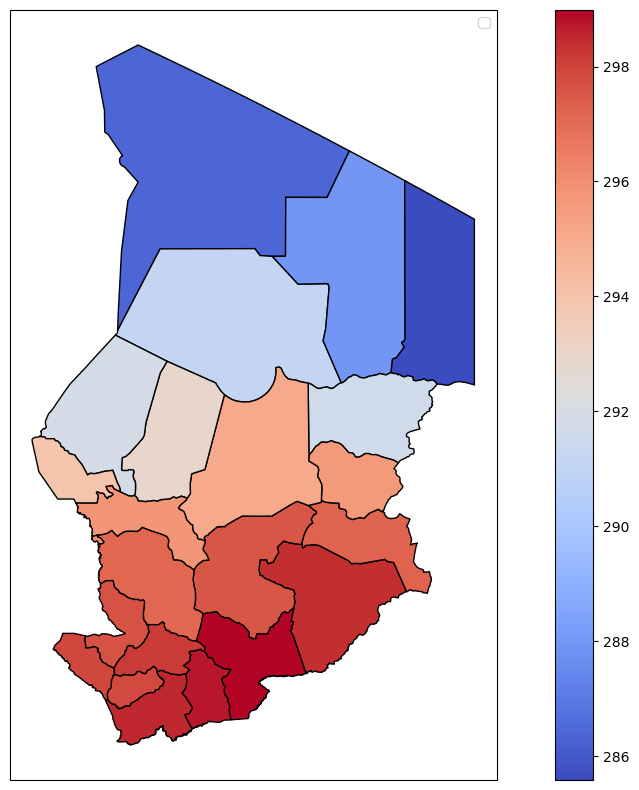

In [427]:
display_in_map(map_data, 't2m')